# Sep 12, 2025, Feb 6, 2026: model comparison

conda env: gt

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import dill as pickle 
from scipy import sparse, stats
from scipy.special import gammaln
import graph_tool.all as gt
from glob import glob
import re 
from tqdm import tqdm
from itertools import combinations
import math
from joblib import Parallel, delayed
# plotting
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cycler import cycler
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

from scipy.stats import wilcoxon, ttest_rel
from statsmodels.stats.multitest import multipletests

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
def get_colorblind_palette(n=20):
    """Return a merged, deduplicated colorblind-safe palette from CUD, Seaborn, and extended sources."""
    base = [
        "#0072B2", "#D55E00", "#009E73", "#CC79A7",
        "#F0E442", "#56B4E9", "#E69F00", "#000000",
        "#999999", "#882255", "#44AA99", "#117733"
    ]
    
    new = [
        "#0173B2", "#DE8F05", "#029E73", "#D55E00",  # D55E00 already in base
        "#CC78BC", "#CA9161", "#FBAFE4", "#949494",
        "#ECE133", "#56B4E9"  # 56B4E9 already in base
    ]
    
    # Deduplicate while preserving order
    seen = set()
    full = base + new
    merged = []
    for color in full:
        if color.lower() not in seen:
            merged.append(color)
            seen.add(color.lower())
    
    return merged[:n]

def setup_mpl(fontsize=7):
    """Configure matplotlib for Illustrator export with Helvetica-style fonts and clean styles."""
    
    CUD_COLORS = get_colorblind_palette()
    
    mpl.rcParams.update({
        # Fonts and layout
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,

        # Export settings
        "svg.fonttype": 'none',
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "text.usetex": False,

        # Axes and ticks
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,

        # Lines
        "lines.linewidth": 1.0,

        # Default color cycle (Color Universal Design)
        "axes.prop_cycle": cycler('color', CUD_COLORS),
    })

    # mpl.rcParams["axes.prop_cycle"] = cycler('color', get_colorblind_palette())

def setup_plotting(palette=None, context="paper", fontsize=7):
    """
    Configure seaborn with 'paper' context and synced matplotlib rcParams.
    """
    setup_mpl(fontsize)

    if palette is None:
        try:
            from cycler import cycler
            cycle = mpl.rcParams['axes.prop_cycle']
            palette = [d['color'] for d in cycle]
        except Exception:
            palette = sns.color_palette("colorblind")

    sns.set_theme(
        context=context,       # use "paper"
        style="white", 
        palette=palette, 
        rc=mpl.rcParams
    )

    setup_mpl(fontsize)

In [3]:
# setup_plotting(context='paper', fontsize=7)
setup_mpl(fontsize=7)
CUD_COLORS = get_colorblind_palette()

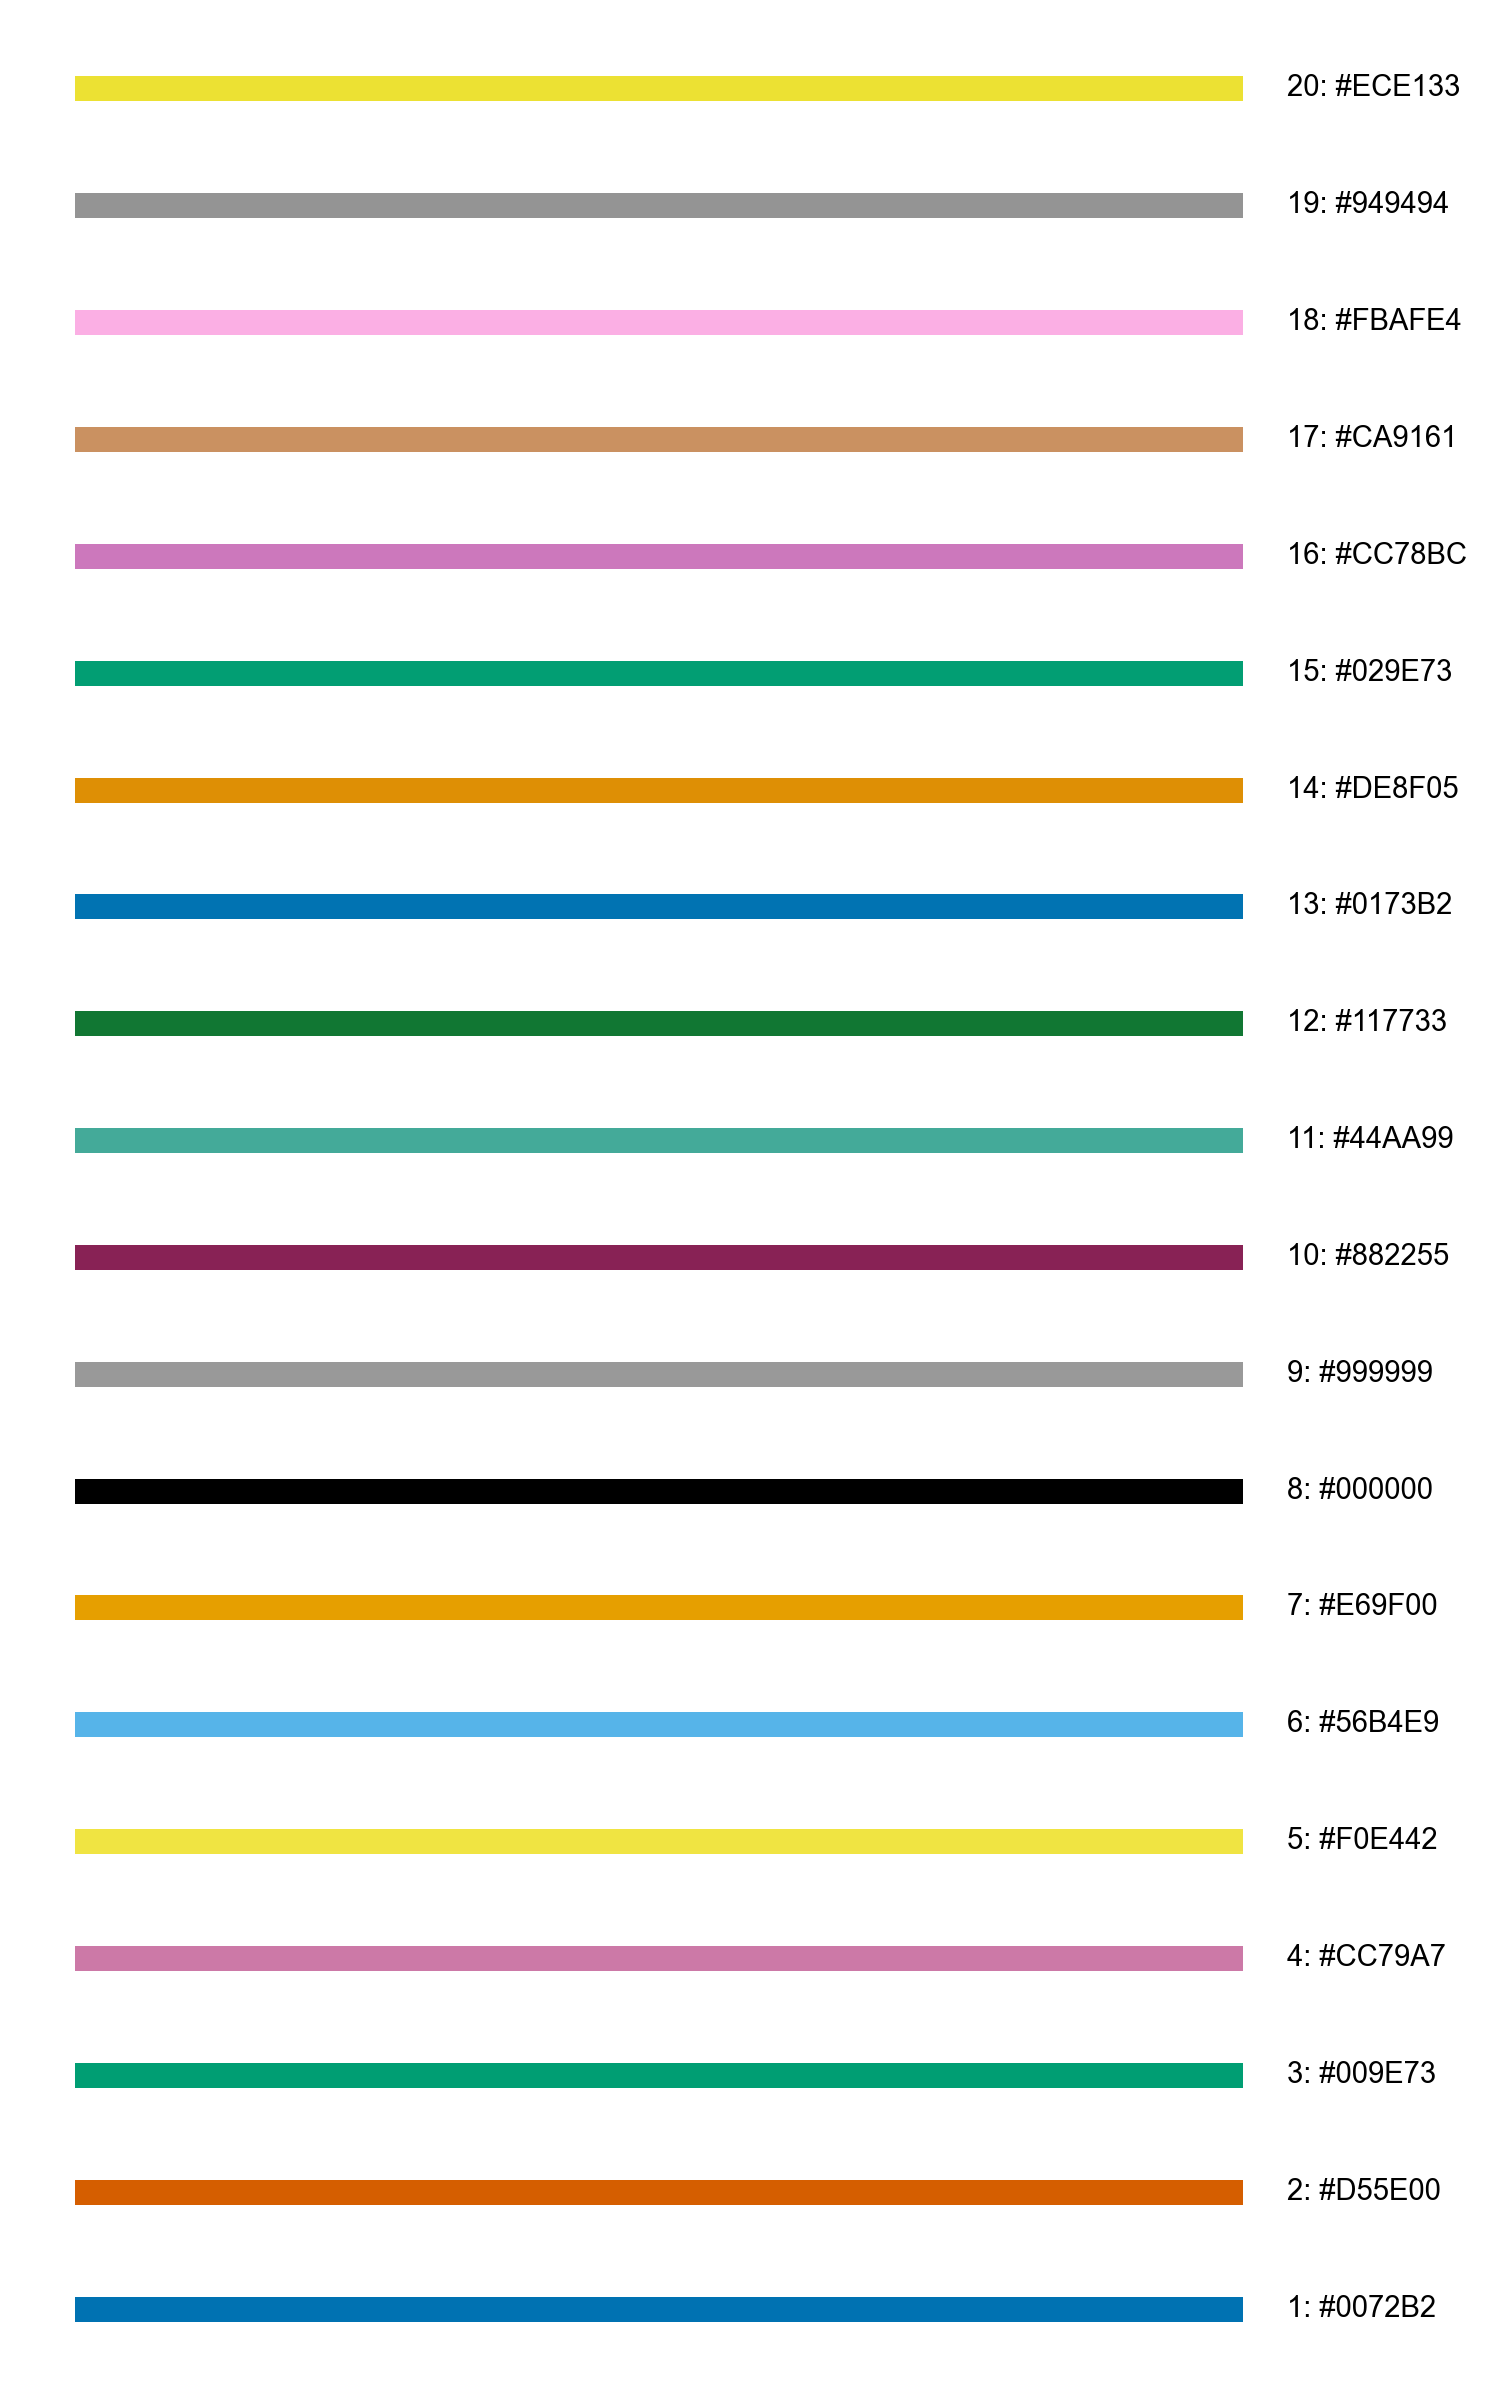

In [4]:
def preview_colorblind_palette():
    colors = get_colorblind_palette()
    n = len(colors)
    
    fig, ax = plt.subplots(figsize=(5, 0.4 * n))
    for i, color in enumerate(colors):
        ax.plot([0, 1], [i, i], color=color, linewidth=6)
        ax.text(1.05, i, f"{i+1}: {color}", va='center', ha='left', fontsize=7)
    
    ax.set_ylim(-0.5, n - 0.5)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function
preview_colorblind_palette()

| Color     | HEX       | Use |
|-----------|-----------|-----|
| Blue      | `#0072B2` | Chain 1 |
| Vermilion | `#D55E00` | Chain 2 |
| Green     | `#009E73` | Chain 3 |
| Purple    | `#CC79A7` | Chain 4 |
| Yellow    | `#F0E442` | Chain 5 |
| Light Blue| `#56B4E9` | Chain 6 |
| Orange    | `#E69F00` | Chain 7 |
| Black     | `#000000` | Chain 8 |

In [5]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

gt.seed_rng(args.SEED)
np.random.seed(args.SEED)

In [6]:
args.ANALYSIS = 'trial-end'
# args.WINDOW = np.arange(5, 8+1)
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'/home/govindas/lab-data/aba'
PARC_DESC = f'NEWMAX_ROIs_final_gm_100_2mm' #f'NEWMAX_ROIs_final_gm_104_2mm' #f'ABA_ROIs_final_gm_36'
ROI_path = (
    f'{BASE_path}/{PARC_DESC}'
)
os.makedirs(ROI_path, exist_ok=True)
TS_path = f'{ROI_path}/roi-timeseries'
os.makedirs(TS_path, exist_ok=True)

ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/analysis-{args.ANALYSIS}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/cond-*/graphs'
SBM_path = f'{ROI_RESULTS_path}/cond-*/model-fits'

In [7]:
def collect_evidences(args, evidence_files):
    ldf = []
    for file in evidence_files[:]:
        pattern = r"cond-(?P<cond>[^/]+).*?sub-(?P<sub>[^/]+)/sbm-(?P<sbm>[^/]+)/B-(?P<B>\d+)"
        match = re.search(pattern, file)
        if match:
            cond = match.group('cond')
            sub = match.group('sub')
            sbm = match.group('sbm')
            B = match.group('B')
        
        with open(f'{file}', 'rb') as f:
            [L] = pickle.load(f)
        
        row = pd.DataFrame(dict(
            sbm=[sbm],
            B=[B],
            sub=[sub],
            cond=[cond],
            L=[-L], # flipped sign to convert evidence to total description length
        ))
        ldf += [row]
    ldf = pd.concat(ldf).reset_index(drop=True)
    ldf = ldf.groupby(by=['sub', 'cond', 'sbm'])['L'].mean().reset_index()
    pdf = ldf.pivot(index=['cond', 'sub'], columns='sbm', values='L')
    return ldf , pdf

In [8]:
def sort_sbms(pdf):
    rank_df = pdf.rank(axis=1, method='min', ascending=True)
    modal_ranks = stats.mode(rank_df.to_numpy(), axis=0).mode
    cols_sorted = [col for _, col in sorted(zip(modal_ranks, pdf.columns))]
    return pdf[cols_sorted]

In [9]:
evidence_files = sorted(glob(f'{SBM_path}/sub-*/sbm-*/B-*/desc-evidence.pkl'))
ldf, pdf = collect_evidences(args, evidence_files)
pdf = sort_sbms(pdf)

In [10]:
pdf

sbm                  nd-h         nd-d         dc-h         dc-d           -a
cond  sub                                                                    
highR ABA602  1727.729505  1755.148365  1764.807069  1776.458024  1805.270523
      ABA603  1658.755792  1681.187132  1689.588431  1696.348437  1775.387976
      ABA604  1637.507237  1654.954067  1662.365940  1669.635730  1679.543419
      ABA606  1670.708906  1690.840436  1715.346002  1722.012256  1784.399906
      ABA607  1697.795591  1721.175765  1727.452864  1733.920732  1819.557479
highT ABA602  1948.617537  1970.162109  1980.839310  1991.015318  2039.121837
      ABA603  1599.480416  1633.420839  1639.282362  1643.192809  1674.849143
      ABA604  1675.385288  1704.001588  1714.645781  1728.422653  1756.094489
      ABA606  1712.399440  1735.690367  1739.971473  1744.309729  1780.811974
      ABA607  1722.510306  1748.951900  1768.428327  1787.122941  1861.862042
lowR  ABA602  1707.471244  1742.601778  1739.598357  1751.957046  1788.528775
      ABA603  1771.685058  1789.300050  1797.033898  1791.227022  1827.147915
      ABA604  1726.330036  1762.231969  1758.611266  1769.646905  1800.025076
      ABA606  1687.159194  1713.202647  1726.527205  1731.198326  1771.641531
      ABA607  1687.426471  1719.489553  1723.503485  1742.433210  1824.978378
lowT  ABA602  1850.900569  1862.395718  1868.918738  1880.840736  1926.577055
      ABA603  1762.605273  1787.605243  1778.959964  1785.282518  1812.535546
      ABA604  1764.011414  1789.530433  1793.363109  1810.697497  1879.382729
      ABA606  1689.456183  1711.072002  1718.480650  1729.431815  1782.877646
      ABA607  1794.112506  1810.574159  1817.501781  1830.714763  1915.700506

In [11]:
pdf = pdf.rename(columns={'nd-d': 'nd-s', 'dc-d': 'dc-s'})
pdf

sbm                  nd-h         nd-s         dc-h         dc-s           -a
cond  sub                                                                    
highR ABA602  1727.729505  1755.148365  1764.807069  1776.458024  1805.270523
      ABA603  1658.755792  1681.187132  1689.588431  1696.348437  1775.387976
      ABA604  1637.507237  1654.954067  1662.365940  1669.635730  1679.543419
      ABA606  1670.708906  1690.840436  1715.346002  1722.012256  1784.399906
      ABA607  1697.795591  1721.175765  1727.452864  1733.920732  1819.557479
highT ABA602  1948.617537  1970.162109  1980.839310  1991.015318  2039.121837
      ABA603  1599.480416  1633.420839  1639.282362  1643.192809  1674.849143
      ABA604  1675.385288  1704.001588  1714.645781  1728.422653  1756.094489
      ABA606  1712.399440  1735.690367  1739.971473  1744.309729  1780.811974
      ABA607  1722.510306  1748.951900  1768.428327  1787.122941  1861.862042
lowR  ABA602  1707.471244  1742.601778  1739.598357  1751.957046  1788.528775
      ABA603  1771.685058  1789.300050  1797.033898  1791.227022  1827.147915
      ABA604  1726.330036  1762.231969  1758.611266  1769.646905  1800.025076
      ABA606  1687.159194  1713.202647  1726.527205  1731.198326  1771.641531
      ABA607  1687.426471  1719.489553  1723.503485  1742.433210  1824.978378
lowT  ABA602  1850.900569  1862.395718  1868.918738  1880.840736  1926.577055
      ABA603  1762.605273  1787.605243  1778.959964  1785.282518  1812.535546
      ABA604  1764.011414  1789.530433  1793.363109  1810.697497  1879.382729
      ABA606  1689.456183  1711.072002  1718.480650  1729.431815  1782.877646
      ABA607  1794.112506  1810.574159  1817.501781  1830.714763  1915.700506

In [12]:
pdf.loc['highT']

sbm,nd-h,nd-s,dc-h,dc-s,-a
sub,,,,,
ABA602,1948.617537,1970.162109,1980.839310,1991.015318,2039.121837
ABA603,1599.480416,1633.420839,1639.282362,1643.192809,1674.849143
ABA604,1675.385288,1704.001588,1714.645781,1728.422653,1756.094489
ABA606,1712.399440,1735.690367,1739.971473,1744.309729,1780.811974
ABA607,1722.510306,1748.951900,1768.428327,1787.122941,1861.862042


In [13]:
def compare_description_lengths(df, test='wilcoxon'):
    results = {}
    for col1, col2 in combinations(df.columns, 2):
        mask = df[[col1, col2]].notna().all(axis=1)
        if mask.sum() > 1:
            x1, x2 = df[col1][mask], df[col2][mask]
            if test == 'wilcoxon':
                stat, pval = wilcoxon(x1, x2, alternative='two-sided')
            elif test == 'ttest':
                result = ttest_rel(x1, x2, alternative='two-sided')
                stat, pval = result.statistic, result.pvalue
            median_diff = (x1 - x2).median()
            better_model = col1 if median_diff < 0 else col2 # smaller DL is better
            results[(col1, col2)] = {
                'Wilcoxon Stat': stat,
                'p-value': pval,
                'Median Diff': median_diff,
                'Better Model': better_model,
            }
    comps_df = pd.DataFrame(results).T
    comps_df['p-value FDR'] = multipletests(comps_df['p-value'], method='bonferroni')[1]
    return comps_df

In [14]:
cond = 'highT'
comps_df = compare_description_lengths(pdf.loc[cond])

In [15]:
comps_df

Wilcoxon Stat p-value Median Diff Better Model p-value FDR
nd-h nd-s           0.0  0.0625  -26.441594         nd-h       0.625
     dc-h           0.0  0.0625  -39.260493         nd-h       0.625
     dc-s           0.0  0.0625  -43.712393         nd-h       0.625
     -a             0.0  0.0625  -80.709201         nd-h       0.625
nd-s dc-h           0.0  0.0625  -10.644192         nd-s       0.625
     dc-s           0.0  0.0625  -20.853209         nd-s       0.625
     -a             0.0  0.0625    -52.0929         nd-s       0.625
dc-h dc-s           0.0  0.0625  -10.176008         dc-h       0.625
     -a             0.0  0.0625  -41.448708         dc-h       0.625
dc-s -a             0.0  0.0625  -36.502245         dc-s       0.625

In [16]:
# def get_long_df(pdf):
#     long_df = pdf.reset_index(drop=True).melt(var_name='SBM', value_name='DL')
#     long_df['chain'] = np.tile(np.arange(pdf.shape[0]), len(pdf.columns))
#     long_df['SBM'] = pd.Categorical(long_df['SBM'], categories=pdf.columns.tolist(), ordered=True)
#     return long_df

In [17]:
def get_long_df(pdf: pd.DataFrame):
    # 1. Get *all* index names automatically
    id_vars = pdf.index.names
    
    # 2. Reset the index and melt
    long_df = pdf.reset_index().melt(id_vars=id_vars, 
                                     var_name='model', 
                                     value_name='dl')
    
    # 3. Set SBM as categorical
    long_df['model'] = pd.Categorical(long_df['model'], 
                                    categories=pdf.columns.tolist(), 
                                    ordered=True)
    return long_df

In [18]:
long_df = get_long_df(pdf)

In [19]:
long_df

,cond,sub,model,dl
0,highR,ABA602,nd-h,1727.729505
1,highR,ABA603,nd-h,1658.755792
2,highR,ABA604,nd-h,1637.507237
3,highR,ABA606,nd-h,1670.708906
4,highR,ABA607,nd-h,1697.795591
...,...,...,...,...
95,lowT,ABA602,-a,1926.577055
96,lowT,ABA603,-a,1812.535546
97,lowT,ABA604,-a,1879.382729
98,lowT,ABA606,-a,1782.877646


In [20]:
def plot_evidences(long_df: pd.DataFrame):
    cond = long_df.at[0, 'cond']
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5), dpi=300)
    fs = 7 # fontsize

    sns.boxplot(
        data=long_df,
        x='model',
        y='dl',
        ax=ax,
        fill=None,
        fliersize=0,
        color='grey',
        width=0.5,
        linewidth=1,
        capprops=dict(linewidth=0),
    )

    sns.stripplot(
        data=long_df,
        x='model', 
        y='dl',
        color=CUD_COLORS[0],
        alpha=0.3,
        ax=ax,
        size=1.5,
        jitter=True,
    )

    # ax = connect_repeated_measures(long_df, ax)
    # ax = annotate_stats(long_df, ax)

    # Axis formatting
    ax.set_ylabel("Total description length", fontsize=fs)
    ax.set_xlabel("SBM", fontsize=fs)
    ax.set_title(f"{cond}", fontsize=fs)
    ax.tick_params(axis='both', labelsize=fs)
    ax.grid(alpha=0.15)
    # ax.legend()
    sns.despine(ax=ax)
    plt.tight_layout()
    
    return fig

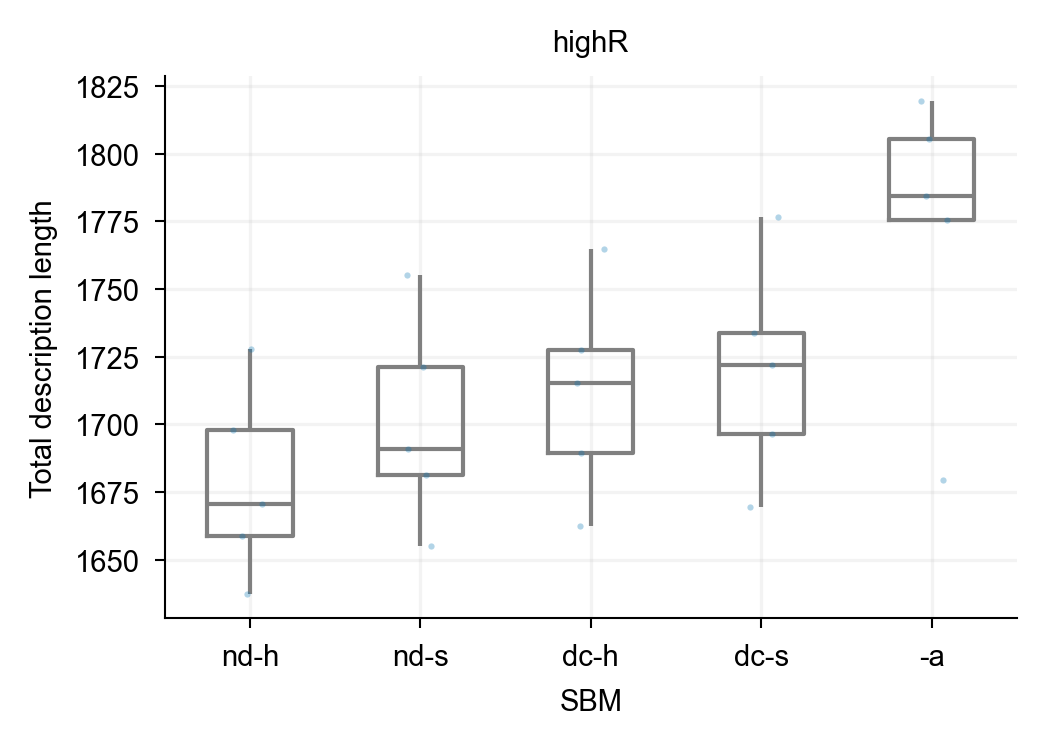

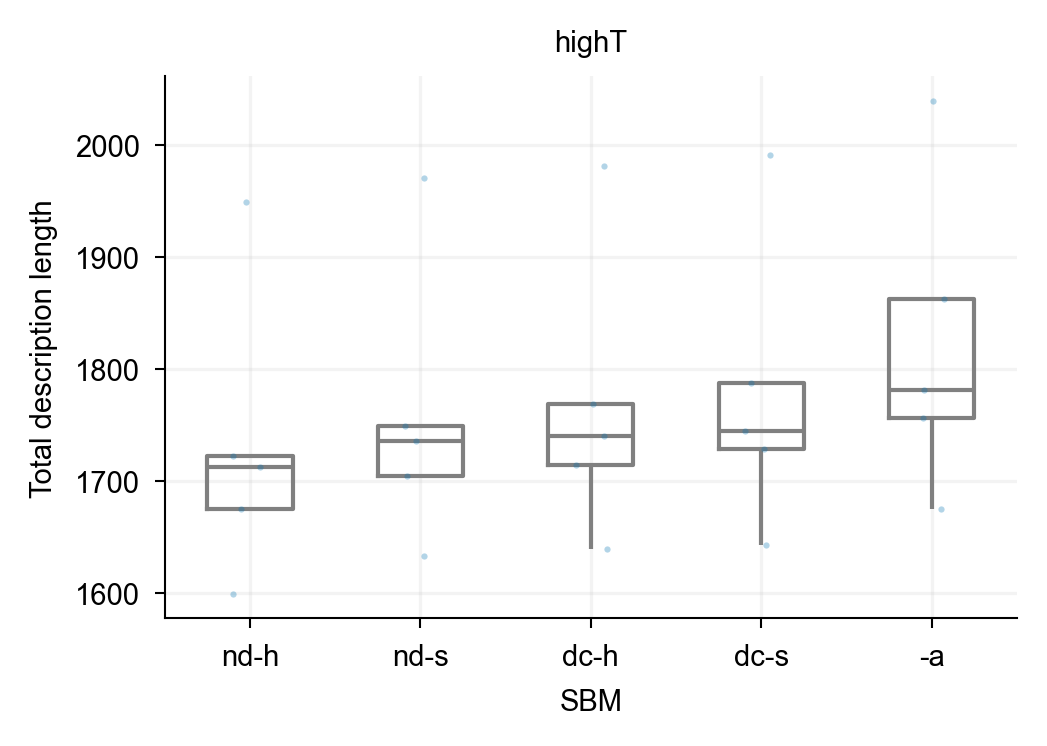

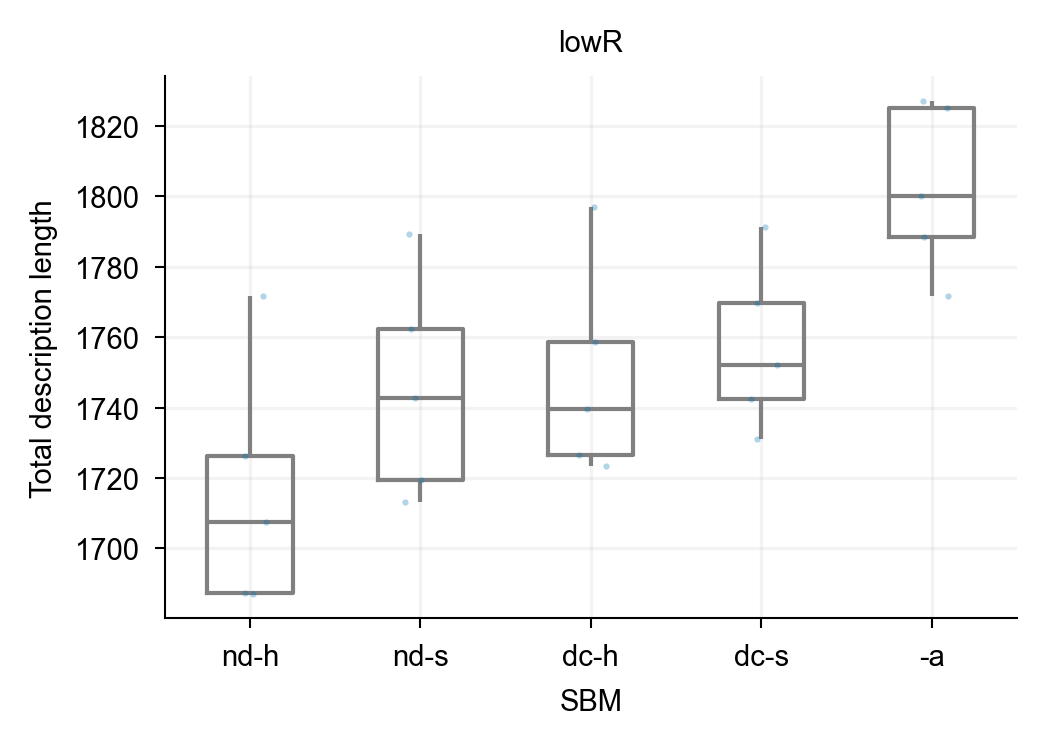

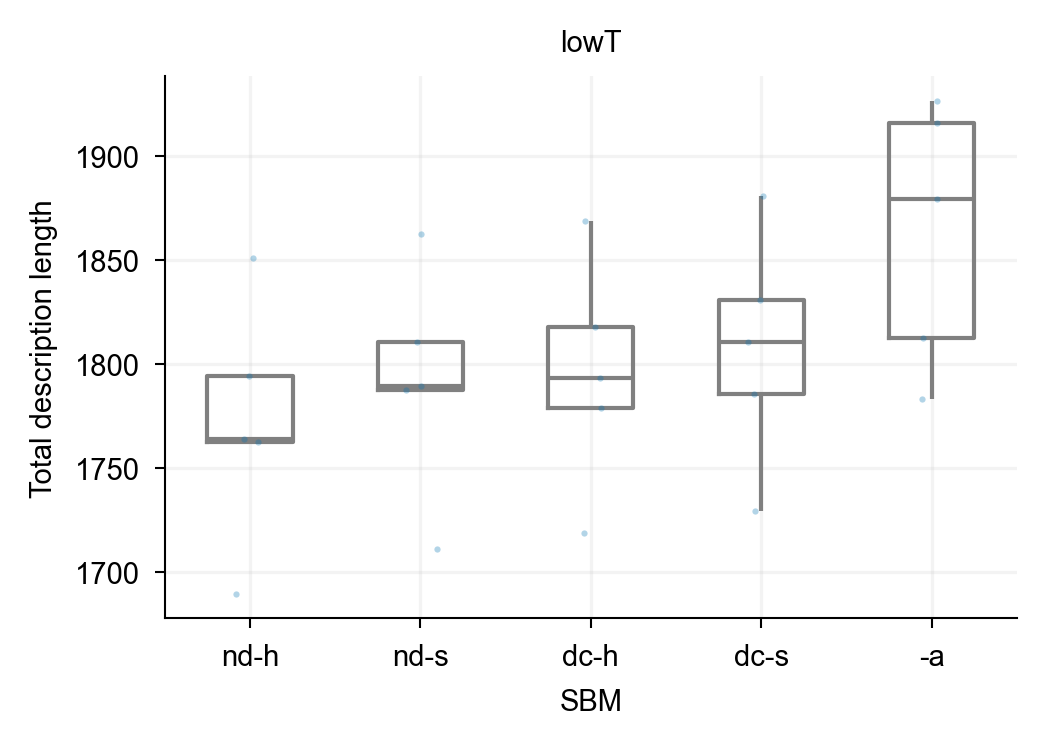

In [21]:
for cond in long_df['cond'].unique():
    fig = plot_evidences(
        long_df[long_df['cond'].isin([cond])].reset_index(drop=True)
    )
    ESTIM_path = f'{ROI_RESULTS_path}/cond-{cond}/estimates'
    os.makedirs(f'{ESTIM_path}/group/model-comparison', exist_ok=True)
    fig.savefig(f'{ESTIM_path}/group/model-comparison/desc-plot.svg', format='svg', bbox_inches='tight', transparent=True)

In [22]:
with open(f'{ESTIM_path}/group/model-comparison/desc-evidence.pkl', 'wb') as f:
    pickle.dump(pdf, f)